# Exploration on reading sonar images in Python

In [1]:
# Imports
from scipy.ndimage import gaussian_filter

import numpy as np
import matplotlib.pyplot as plt

from skimage.registration import phase_cross_correlation
from skimage.transform import (
    warp_polar,
    resize,
    SimilarityTransform,
    warp,
)
from skimage.filters import difference_of_gaussians, window


from utils import binlog, image

In [2]:
equalize = False
start_frame = 75867

## Helper functions

In [3]:
def fft(data):
    return np.fft.fftshift(np.fft.fft2(data))

def to_magnitude_and_phase(data):
    # Get magnitude
    magnitude = np.abs(data)

    # Get phase
    phase = np.angle(data)

    return magnitude, phase

def rectangular_mask(data, offset = 10, sigma = 7):
    mask = np.zeros(data.shape)
    mask[offset:-offset, offset:-offset] = 1
    # gaussian blur the mask
    return (data * gaussian_filter(mask, sigma=sigma)).astype(np.uint8)

def log_polar_transform(data, radius=None, order=None):
    if (radius is None):
        radius = data.shape[0] // 2
    shape = data.shape
    return warp_polar(data, radius=radius, scaling='log', order=order, output_shape=shape)

def phase_correlation(a, b, normalize = True):
    # DFT
    ffta = fft(a)
    fftb = fft(b)
    # Cross power spectrum
    cps = ffta * np.conj(fftb)
    if normalize: cps = cps / np.abs(ffta * fftb)
    # Phase Correlation Matrix by Inverse DFT
    pcm = np.fft.ifft2(cps).real
    
    return pcm

def fourier_mellin(a, b):
    # DFT
    fft_a, phase_a = to_magnitude_and_phase(fft(a))
    fft_b, phase_b = to_magnitude_and_phase(fft(b))
    # Log Polar Transform
    a = log_polar_transform(fft_a)
    b = log_polar_transform(fft_b)
    # Phase Correlation
    return phase_correlation(rectangular_mask(a), rectangular_mask(b))

## 1. Mask images with Hanning window
- Using input images with good overlap.
- Padding images so that when we rotate them, we don't lose any information.

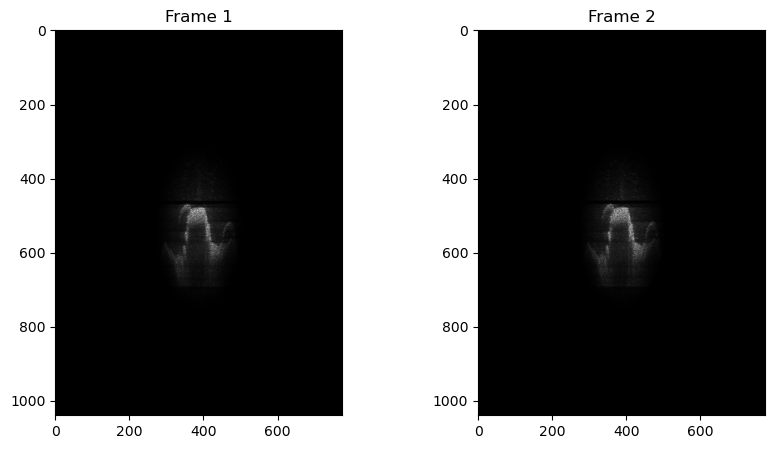

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = axes.ravel()

generator = binlog.read_ping("logs/log-multibeam.bez", start_frame=75912)

_, a, _, aperture, _ = next(generator)
# for i in range(76873 - 75912): next(generator)
_, b, _, aperture, _ = next(generator)


mask = window('hann', a.shape)

# Pad the images by half of the image size
a = np.pad(a, np.max(a.shape) // 2) / np.max(a)
b = np.pad(b, np.max(b.shape) // 2) / np.max(b)
mask = np.pad(mask, np.max(mask.shape) // 2)

a *= mask
b *= mask

# Create a mask (haning window)
ax[0].set_title("Frame 1")
ax[0].imshow(a, cmap='gray')
ax[1].set_title("Frame 2")
ax[1].imshow(b, cmap='gray')
plt.show()

## 2. Bandpass filter

## 4. Fourier transform

## 5. Log-polar transform

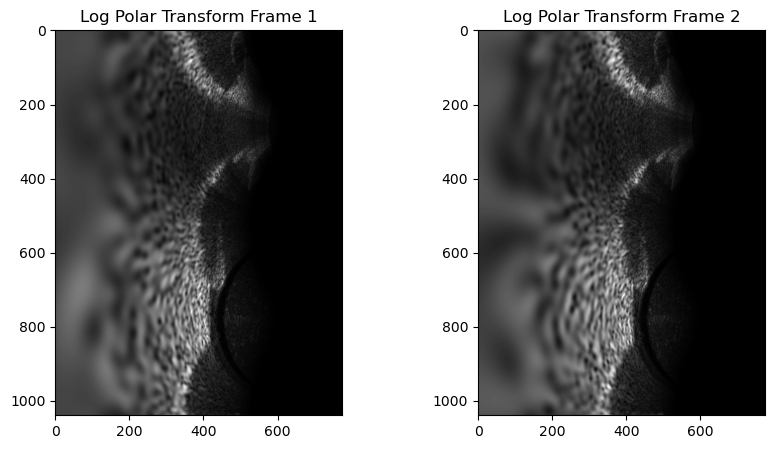

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = axes.ravel()

### Apply Log Polar Transform
radius = a.shape[0]
log_a = log_polar_transform(a, radius, 3)
log_b = log_polar_transform(b, radius, 3)

ax[0].set_title("Log Polar Transform Frame 1")
ax[0].imshow(log_a, cmap='gray')
ax[1].set_title("Log Polar Transform Frame 2")
ax[1].imshow(log_b, cmap='gray')
plt.show()

## 6. Phase Correlation

My implementation of the phase correlation can only reach pixel precision. Good to understand how it works.

Comments:
- Angle is in the y-axis and needs to be scaled to 360 degrees. Rotation comes in positive degrees (Same result as 360 - angle)
- Scale is in the x-axis

PCM: (1040, 776)
Max: 0.076152794023717
Min: -0.05086989667137093
Shifts [0, 0]
Angle: 0.0
Scale: 1.0


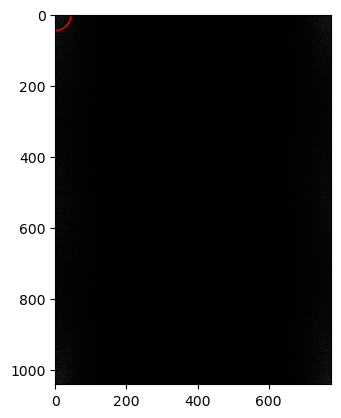

In [34]:
### Apply Phase Correlation
pcm = (phase_correlation(log_a, log_b, True))
print('PCM:', pcm.shape)
print('Max:', np.max(pcm))
print('Min:', np.min(pcm))

plt.imshow((np.abs(pcm)), cmap='gray')
angle, scale = np.unravel_index(np.argmax(pcm), pcm.shape)


plt.scatter([scale], [angle], color='red', facecolors='none', s=500)

print('Shifts', [angle, scale])
angle = angle * 360 / pcm.shape[0]
print('Angle:', angle)

klog = a.shape[1] / np.log(radius)
scale = np.exp(scale / klog)
print('Scale:', scale)

plt.show()

Scikit Image's implementation of phase correlation is much more accurate. It can reach subpixel precision and disambiguates between angles. No visualizations are provided. 

In [35]:
shifts, error, phasediff = phase_cross_correlation(
    log_a, log_b, upsample_factor=10, normalization=None, disambiguate=True
)
print('Shifts:', shifts)
print('Shape:', log_a.shape)
angle = shifts[0] * 360 / log_a.shape[0]
print('Angle:', angle)
klog = a.shape[1] / np.log(radius)
scale = np.exp(shifts[1] / klog)
print('Scale:', scale)

Shifts: (-0.5, -0.39999999999997726)
Shape: (1040, 776)
Angle: -0.17307692307692307
Scale: 0.9964254883717616


In [36]:
# Create transform around center
center = np.array(a.shape) // 2
rtform = SimilarityTransform(translation=-center)
rtform += SimilarityTransform(rotation=np.deg2rad(angle))
rtform += SimilarityTransform(scale=1, translation=center)

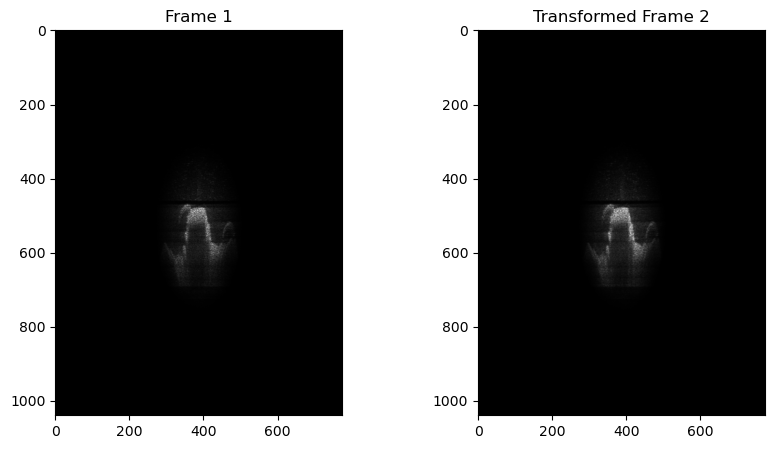

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = axes.ravel()

### Apply rotation and scaling
rotated_b = warp(b.copy(), rtform.inverse, output_shape=a.shape)
rotated_mask_b = warp(mask.copy(), rtform.inverse, output_shape=a.shape)

ax[0].set_title("Frame 1")
ax[0].imshow(a, cmap='gray')
ax[1].set_title("Transformed Frame 2")
ax[1].imshow(rotated_b, cmap='gray')
plt.show()

In [39]:
# fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# ax = axes.ravel()
# 
# ### Band-pass filter rotated image
# blurred_rotated_b = difference_of_gaussians(rotated_b, 5, 20)
# 
# ax[0].set_title("Band-pass Filtered Frame 1")
# ax[0].imshow(blurred_a, cmap='gray')
# ax[1].set_title("Band-pass Filtered Transformed Frame 2")
# ax[1].imshow(blurred_rotated_b, cmap='gray')
# plt.show()

In [41]:
# fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# ax = axes.ravel()
# 
# ### Apply mask
# # Add black border to the mask
# rotated_mask_b = np.pad(rotated_mask_b, 100, mode='constant', constant_values=0)
# # Resize mask to image size
# rotated_mask_b = resize(rotated_mask_b, rotated_b.shape, anti_aliasing=True)
# # Gaussian blur the mask
# rotated_mask_b = gaussian_filter(rotated_mask_b, sigma=10) 
# 
# rotated_masked_b = blurred_rotated_b * rotated_mask_b
# 
# ax[0].set_title("Masked Frame 1")
# ax[0].imshow(masked_a, cmap='gray')
# ax[1].set_title("Masked Frame 2")
# ax[1].imshow(rotated_masked_b, cmap='gray')
# plt.show()

In [42]:
shifts, error, phasediff = phase_cross_correlation(
    a, rotated_b, upsample_factor=10, normalization=None, disambiguate=True
)
# shifts = shifts / scale
print('Shifts:', shifts)

ttform = SimilarityTransform(translation=[shifts[1], shifts[0]])

Shifts: (0.2, -0.6000000000000227)


/Users/jp.pinob/miniconda3/envs/thesis/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/jp.pinob/miniconda3/envs/thesis/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


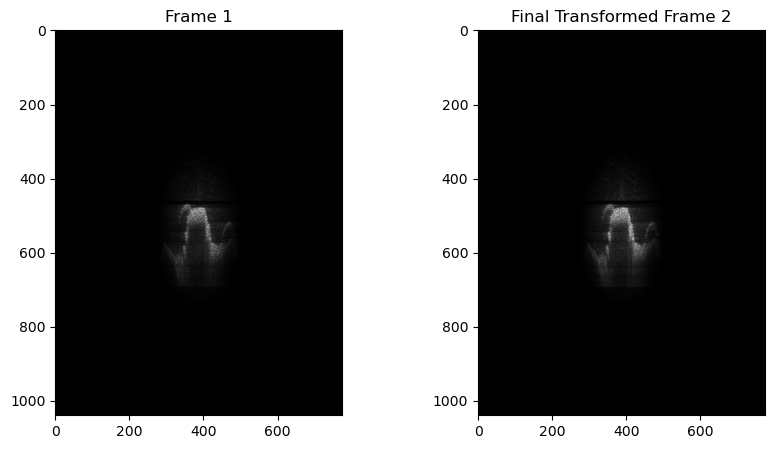

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = axes.ravel()

# Combine transformations
ctform = rtform + ttform

# Apply translation
final_b = warp(b.copy(), ctform.inverse, output_shape=a.shape)

ax[0].set_title("Frame 1")
ax[0].imshow(a, cmap='gray')
ax[1].set_title("Final Transformed Frame 2")
ax[1].imshow(final_b, cmap='gray')
plt.show()

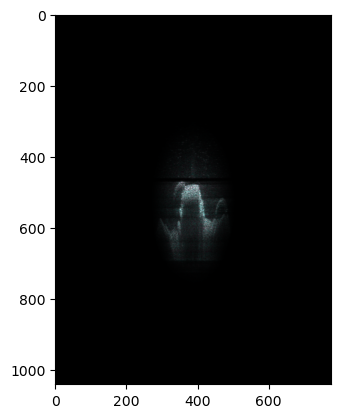

In [44]:
# Overlay the images
r = a / np.max(a)
g = final_b / np.max(final_b)
b = np.max([r, g], axis=0)
overlay = np.stack([r, g, b], axis=-1)

plt.imshow(overlay)
plt.show()

## Next steps

Next steps will be to build this into a pipeline resembling this:

![Pipeline](documentation/images//FourierMellinPipeline.png)

(From An FFT-Based Technique for Translation, Rotation, and Scale-Invariant Image Registration)
